# Radio-loud or radio-quiet sources Justification
Sometimes we need to determine if a source is radio-loud or radio-quiet, the usual way is to calculate the radio-loudness parameter, this parameter is defined as: $R=\frac{f_{v}(5GHZ)}{f_{v}(5100 A)}$, this frequency and wavelength is the observed value in rest frame, the value R=10 is the break between radio loud and radio quiet sources. 


Here we need to calculate the radio loudness of G5 in Qiong Li's paper(CO(3-2),prep), but what I have is the optical image of this source(HST image of F160W filter the cneter wavelength of which is 15000 A) and the radio catalog in the same sky area from FIRST (the center frequency is 1500 GHz), the rest-frame wavelength and frequency is $\lambda_{rest}$=4545 A and $f_{rest}$=4.28 GHz. This value is close to the value required for radio loudness calculation. The results calculated is valuable in some aspect.
#### Basic information of selected region in FIRST catalog
The center coordinate of this field of view is 
**RA=14:41:24.5043**
**DEC=+40:03:09.674**
**Radius=300''**
within this radius, we found three sources and the background RMS is .139 mJy/beam, .131 mJy/beam, .138 mJy/beam. So the mean background RMS is .136 mJy/beam. 

In [22]:
## calculate the mean RMS of the background within the local region.
import numpy as np
RMS=np.array([.139,.138,.131])
RMS.mean()

0.136

Usually, we put 3 $\sigma$ as the threshold which means the flux of a source must be larger than 3 $\sigma$ of the background. Beacause the resolution of this radio observation is 5'' which means one beam corresponds to 5'', so the background mean RMS for 1'' is .136/5=0.0272 mJy

In [5]:
import os
import astropy
from astropy import units as u
from astropy import constants as const
from astropy import visualization
from astropy.cosmology import Planck15 as cosmo
from matplotlib import pyplot as plt
f_radio=3*RMS.mean()*astropy.units.mJy/(5.*u.arcsec)
f_radio

<Quantity 0.0816 mJy / arcsec>

on the other hand, we also need the flux of optical band, fortunately, we have the HST bw image of filter F160W the effective wavelength of which is 1.6 $\mu m$. We extract all of the flux within PSF and calculate its flux. We use **photutils(package based on astropy)** to extract its flux.
Now, what we need to do is that do photometry calibration to this image and calculate the flux of G-5, the natural units for the image is electrons/s and we need to convert it to flux density, fortunately, there're a few of keywords in the header discribe how to do this conversion. **PHOTFLAM** convert electrons/s to $erg/s/cm^{2}/A$, its unit is $erg/s/cm^{2}/electrons$, **PHOTFNU** convert electrons/s to $erg/s/cm^{2}/A$, here we use PHOTFLAM to do this conversion.

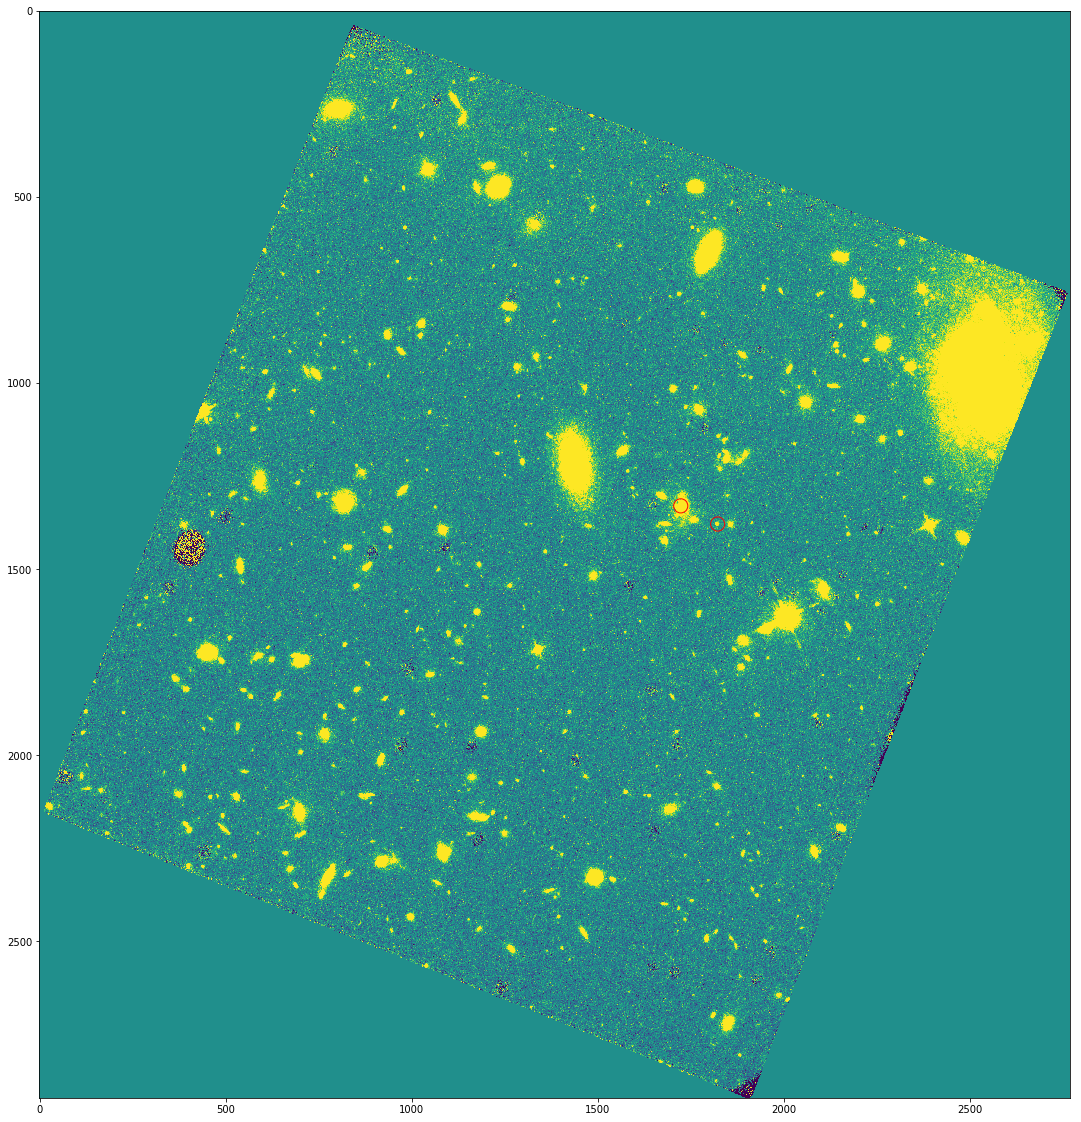

-5.540689846908854e-38 erg / (cm2 Hz s)
-6.392927513733631e-23 erg / (Angstrom cm2 s)


In [101]:
import photutils

#open the HST image and extract it
os.chdir('/Users/shiwuzhang/W&S/ASTRO/MAMMOTH_KCWI/MMAMOTH1/mammoth-1_HST_NB_CO')
fitsfile=astropy.io.fits.open('HST_WFC3_MAMMOTH.fits')
img_array=np.around(fitsfile[1].data,decimals=8)
#plot the HST image
norm=visualization.ImageNormalize(img_array,interval=visualization.ZScaleInterval(),
                                         stretch=visualization.LinearStretch())
fig,ax=plt.subplots(1,1)
ax.scatter(1821.6508,1378.8726, s=200, facecolors='none', edgecolors='r')
ax.scatter(1722.4676,1330.1235, s=200, facecolors='none', edgecolors='r')
ax.imshow(img_array,norm=norm)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

#convert elecytons/s to flux density
flux_img=img_array*fitsfile[1].header['PHOTFLAM']*u.erg/u.s/(u.cm**2)/u.AA

#convert erg/s/cm^2/A to erg/s/cm^2/Hz
#the conversion equation is f_mu=f_lamda*(lamda**2/c)
#we use the value of keyword PHOTPLAM as the mean wavelength to achieve this conversion.
lamda=img_array*fitsfile[1].header['PHOTPLAM']*u.AA
flux_img_mu=(flux_img*(lamda**2)/const.c).to(u.erg/u.s/(u.cm**2)/u.Hz)
print(flux_img_mu[1000,1000])
print(flux_img[1000,1000])

we then extract the optical flux density within this aperture, the results shows below.

In [87]:
#difine and create the aperture, the coordinate and radius.
#we use the physical coordinate instead of the wcs, because there's small offset beatween the 
#wcs calculated from ds9 and astropy.
position=[1821.6508,1378.8726]
aperture=photutils.CircularAperture(position,r=6.6667)
#generate the photometry catalog of this source
photo_catalog=photutils.aperture_photometry(flux_img_mu,aperture)
flux_optical=photo_catalog['aperture_sum']
flux_optical

<Quantity [1.57968523e-31] erg / (cm2 Hz s)>

from the figure we get that the angular scale of this object is 0.482 arcsec. We then calculate the radio background flux within this aperture.

In [100]:
flux_radio=(f_radio*.482*u.arcsec).to(u.erg/u.s/(u.cm**2)/u.Hz)

With this results, we can now calculate the upper limit radio-loudness for this source.

In [89]:
R=flux_radio/flux_optical
R.value

array([2489.81247299])

FAB's paper about MMAMOTH-1 fit the spectra of source-B in radio range, from the figure we got its flux density at $\lambda_{obs}$=2*$10^{6} \mu m$ is $f_{\mu}=0.05 mJy$. with this value, we can also calculate the radio-loudness for Source-B

In [108]:
#difine and create the aperture, the coordinate and radius.
#we use the physical coordinate instead of the wcs, because there's small offset beatween the 
#wcs calculated from ds9 and astropy.
position=[1722.4676,1330.1235]
aperture=photutils.CircularAperture(position,r=8)
#generate the photometry catalog of this source
photo_catalog=photutils.aperture_photometry(flux_img_mu,aperture)
flux_optical=photo_catalog['aperture_sum']
photo_catalog

id,xcenter,ycenter,aperture_sum
,pix,pix,erg / (cm2 Hz s)
int64,float64,float64,float64
1,1722.4676,1330.1235,2.8060038798482596e-31


In [107]:
flux_radio=(0.05*u.mJy).to(u.erg/u.s/(u.cm**2)/u.Hz)
R=flux_radio/flux_optical
R

<Quantity [1781.89347346]>

# Virial Radius and Temperature

Calculate the virial radius and temperature of DM halo with given mass

$r_{\mathrm{vir}}=\left(\frac{2 G}{H_{0}^{2} \Delta_{c}}\right)^{1 / 3} M^{1 / 3}(1+z)^{-1} \Omega_{m}^{-1 / 3}$

Let the thermal mothion energy equal to gravitational energy per volume, can we get virial temperature. $\mu$ is mean molecular weight $\mu =\frac{m}{m_{H}}$

$T_{\mathrm{vir}}=\frac{1}{5} \frac{G M \mu m_{P}}{r_{\mathrm{vir}} k_{B}}=\frac{1}{5} \frac{\mu m_{P}}{k_{B}} V_{c}^{2}$

The virial velocity is $V_{c}=(GM/r_{vir})^{1/2}$

In [25]:
#viriable defination
M=1e13*u.M_sun
m=1*u.M_p
z=2.308
omega_m=0.939445
delta_c=200
mu=1.05
H0=(cosmo.H(0))

#virial radius
r_t1=(2*const.G/(delta_c*(H0)**2))**(1/3)
r_t2=((M**(1/3))/(1+z))*omega_m**(-1/3)
r_vir=r_t1*r_t2
print(r_vir.to(u.kpc))

#virial temperature
T_vir=.2*(const.G*M*mu*m)/(r_vir*const.k_B)
print(T_vir.to(1e6*u.K))

#virial velocity
v_c=np.sqrt(const.G*M/r_vir)
print(v_c.to(u.km/u.s))

140.2063276052804 kpc
7.80418248698316 1e+06 K
553.855837420448 km / s


# Estimate AGN outflow energy rate and Halo binding energy

Using the equation derive by Heckman et al. 1990:

$E_{\mathrm{kin}} \approx 1.5 \times 10^{46} r_{10}^{2} v_{1000}^{3} n_{0.5} \operatorname{erg} \mathrm{s}^{-1}$

where $r_{10}$ is the observed CIV emission region in unit of 10kpc, $v_{1000}$ is the offset between the two velocity component in unit of 1000km/s, $n_{0.5}$ is the gas density in unit of $0.5 cm^{-3}$. In our situation, we assume that

$v_{1000}=0.8$,

$r_{10}=7.5$,

$n_{0.5}$ range in 1-4.

In [35]:
v=0.8
r=7.5
n=np.linspace(1,4,10)
E_r=(1.5e46)*(r**2)*(v**3)*n
E_r=E_r*(u.erg/u.s)
E=E_r*30*u.Myr
M_r=2*E_r/(v_c**2)
print(E_r)
print(M_r.to(1e3*u.M_sun/u.yr))
print(E.to(u.erg))

[4.320e+47 5.760e+47 7.200e+47 8.640e+47 1.008e+48 1.152e+48 1.296e+48
 1.440e+48 1.584e+48 1.728e+48] erg / s
[ 4469.96382987  5959.95177315  7449.93971644  8939.92765973
 10429.91560302 11919.90354631 13409.8914896  14899.87943288
 16389.86737617 17879.85531946] 1000 solMass / yr
[4.08986496e+62 5.45315328e+62 6.81644160e+62 8.17972992e+62
 9.54301824e+62 1.09063066e+63 1.22695949e+63 1.36328832e+63
 1.49961715e+63 1.63594598e+63] erg


mass flow and Eddington limit of central BH

We use newton grivity to estimate the halo binding energy.

$E_{b}=\frac{GM^{2}}{r_{vir}}$

In [30]:
Eb=(const.G*M*M)/r_vir
print(Eb.to(u.erg))

6.099773384703735e+61 erg


# How does the NB4000 on Subaru cover lyman$\alpha$ line and z~2.

Masami who's the best in Japan working on High-z galaxies want to know the coverage of NB4000 filter on Subaru to the lyman$\alpha$ emission at z~2. So, here I'm going to find the coverage of NB4000 and plot the coverage on the spectra.

In [16]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from spectral_cube import SpectralCube
from astropy.io import fits

In [3]:
#read the cube 
cube_fits=SpectralCube.read('/Users/shiwuzhang/W&S/ASTRO/MAMMOTH_KCWI/1441+4003_comb_ss_icubes.fits',hdu=0)
cube_data,cube_wavelength=cube_fits._data,cube_fits.spectral_axis
#read the NB4000 response curve
resp_data=np.genfromtxt('/Users/shiwuzhang/W&S/ASTRO/MAMMOTH_KCWI/Subaru_nb4000.txt')

/usr/local/lib/python3.7/site-packages/spectral_cube/cube_utils.py:445: UserWarning: Could not parse unit FLAM16
  warnings.warn("Could not parse unit {0}".format(bunit))


In [4]:
# cut the cube, select only the region with strong lyman-alpha emission
subcube=cube_data[:,30:40,10:20]
spec=np.mean(np.mean(subcube,axis=1),axis=1)
spec=spec*1e-16/1e-19

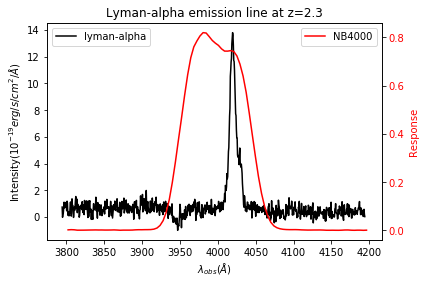

In [5]:
fig,ax1=plt.subplots(1,1)
line1,=ax1.plot(cube_wavelength.value[500:1300],spec[500:1300],color='black',label='lyman-alpha')
ax1.set_xlabel(r'$\lambda_{obs}(\AA)$')
ax1.set_ylabel(r'Intensity($10^{-19} erg/s/cm^{2}/\AA$)')
ax1.legend(loc='upper left')
ax2=ax1.twinx()
ax2.set_ylabel('Response',color='red')
line2,=ax2.plot(resp_data[:,0],resp_data[:,1],color='red',label='NB4000')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')
ax1.grid(False)
ax2.grid(False)
plt.title('Lyman-alpha emission line at z=2.3')
plt.savefig('spec&resp.png',dpi=600)

In [15]:
print(cube_wavelength[515],cube_wavelength[1305])
print(resp_data[0],resp_data[-1])
# len(resp_data[:,0])

3801.999999999999 Angstrom 4196.999999999999 Angstrom
[3.8023e+03 2.6000e-03] [4.1963e+03 1.3000e-03]


Calculate flux out of the response curve, to determine if this narrowband is good for the observation

In [48]:
#interpolate the response curve to fit the size of spectra
func_inter=interpolate.interp1d(resp_data[:,0],resp_data[:,1],kind='cubic')
resp_inter=func_inter(cube_wavelength[520:1300].value)
lyman_line=spec[520:1300]
lyman_wave=cube_wavelength[520:1300].value

#calculate the total flux of lyman alpha emission line and the flux out of the response curve
delta_lambda=(cube_wavelength[1]-cube_wavelength[0]).value
lyman_flux=np.sum(lyman_line[400:470])*delta_lambda
lyman_flux_resp=np.sum(lyman_line[400:470]*resp_inter[400:470])*delta_lambda
lyman_flux_out=lyman_flux-lyman_flux_resp
print(lyman_flux_out)
print(lyman_flux_resp)

45.59742794276602
121.52865543125742


To have a detailed insight into the coverage, I extract the spectra from different part of the nebula and calculate the covered flux.